In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
import nfft
import xrft

%matplotlib inline

In [2]:
# input_path = '/home/hgrosselindemann/Documents/GitHub/TORI/'
input_path = '/Users/2311043/Documents/GitHub/TORI/'


grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [3]:
time = np.arange(datetime(2015,3,1,0,0,0), datetime(2015,4,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [4]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],time)
},data_vars={
    'u':(['y','x','time'],vel_data['u0_monthly']),
    'v':(['y','x','time'],vel_data['v0_monthly'])
})

velocity = velocity.transpose('time','y','x')

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)
velocity['abs'] = np.sqrt(velocity['u']**2 + velocity['v']**2)

# seasonal means

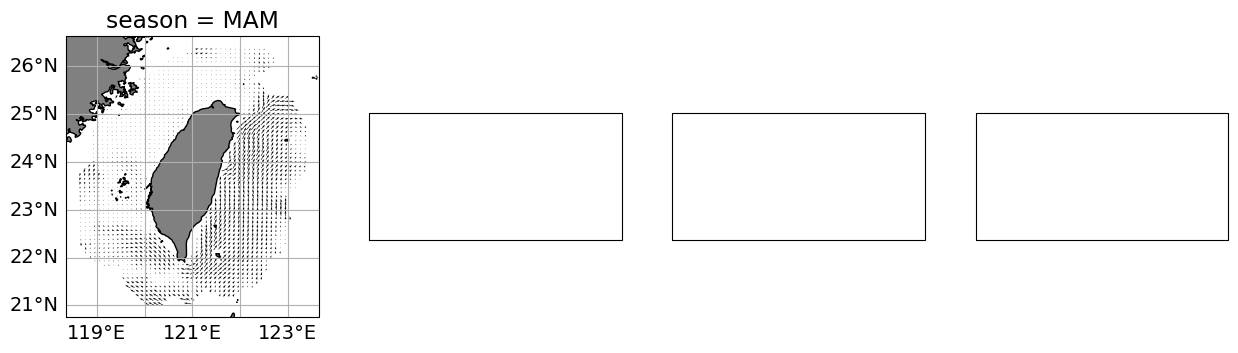

In [139]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
velocity.groupby('time.season').mean(dim='time').sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax1)
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

# Movie

In [9]:
fig = plt.figure(figsize=(10,10))

def custom_plotfunc(ds,fig,tt,framedim='time',**kwargs):
    ax = fig.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ds.isel({framedim:tt}).plot.quiver('lon','lat','u','v',ax=ax)
    ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
    ax.gridlines(draw_labels=True)
    return None,None
    
# mov = Movie(velocity,custom_plotfunc,input_check=False)
# mov.save('movie_2015.mp4',overwrite_existing=True,framerate=8)

<Figure size 1000x1000 with 0 Axes>

# De-mean and De-trend

In [5]:
def demean_xarray(da,dim):
    return da - da.mean(dim=dim)

def detrend_xarray(da,dim):
    axis_num = [da.get_axis_num(d) for d in dim]
    dt = xr.apply_ufunc(
                linear_detrend,
                da,
                axis_num[0],
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
    return dt
    
def linear_detrend(da,axis):
    ds = da.copy()
    mask = ~np.isnan(ds)
    if mask.sum() == 0:
        return ds
    else:
        ds[mask] = scipy.signal.detrend(ds[mask],axis=axis)
        return ds

In [6]:
u_demeaned = demean_xarray(velocity.u,dim='time')
u_detrended = detrend_xarray(u_demeaned,dim=['time'])

v_demeaned = demean_xarray(velocity.v,dim='time')
v_detrended = detrend_xarray(v_demeaned,dim=['time'])

# interpolation

In [22]:
test = velocity.u[:,10,10].copy()
dummy = test.interpolate_na(dim='time',method='linear')

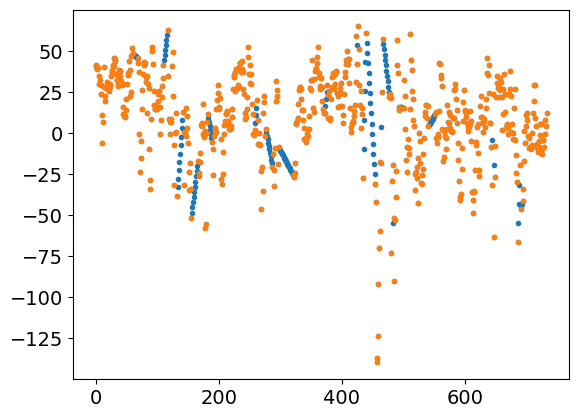

In [23]:
plt.plot(dummy,'.')
plt.plot(test,'.')


# time filtering

In [7]:
window = np.zeros((744))
window[330:372] = np.linspace(0,1,42)
window[372:414] = np.linspace(1,0,42)

In [8]:
data = u_detrended[:,10,10].copy().data
mask = ~np.isnan(data)
    
N_freq = len(data)
k = -N_freq//2 + np.arange(N_freq)

data_masked = data[mask]
t = np.linspace(0, 1,N_freq)[mask]

f_k = nfft.ndft_adjoint(t,data_masked,N_freq)

f_k_filtered = f_k*window

data_rec = nfft.ndft(t, f_k)/N_freq
data_filtered = nfft.ndft(t, f_k_filtered)/N_freq

data[mask] = data_filtered

data_filtered = xr.Dataset(coords={
        'time':velocity.time
    },data_vars = {
        'masked':('time',data)
    })

C:\Users\2311043\AppData\Local\Temp\ipykernel_12752\4285487208.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  data[mask] = data_filtered


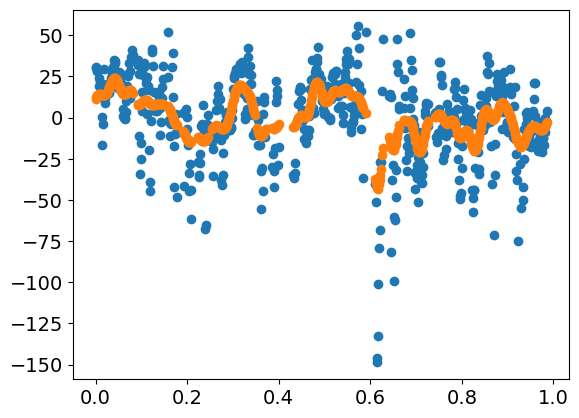

In [123]:
plt.scatter(t,data_rec)
plt.scatter(t,data_filtered)

# Spectral analysis

## uniform FFT

In [6]:
# try xrft.power_spectrum

In [35]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [36]:
mask = ~np.isnan(u_detrended[:,10,10].interpolate_na(dim='time',method='linear'))
freq,ps,psd = spectrum1(u_detrended[:,10,10].interpolate_na(dim='time',method='linear')[mask])

## non-uniform DFT

In [9]:
def nudft(data):
    mask = ~np.isnan(data)
    
    N_freq = len(data)
    k = -N_freq//2 + np.arange(N_freq)
    
    data_masked = data[mask]
    t = np.linspace(0, 1,N_freq)[mask]
    
    f_k = nfft.ndft_adjoint(t,data_masked,N_freq)
    ps = np.abs(f_k)**2/N_freq**2
    psd = ps * N_freq
    freq = k/N_freq
    return_data = xr.Dataset(coords={
        'time':data.time[mask]
    },data_vars = {
        'reconstructed':('time',nfft.ndft(t, f_k)/N_freq),
        'masked':('time',data_masked.data)
    })
    
    return freq,f_k,ps,psd,return_data

In [13]:
freq,f_k,ps,psd,data_reconstructed = nudft(u_detrended[:,10,10])
# freq,f_k_filtered,ps_filtered,psd_filtered,data_reconstructed_filtered = nudft(data_filtered.masked)

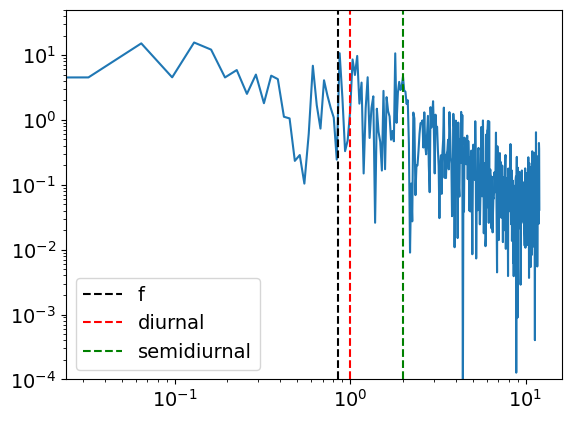

In [14]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.loglog(freq*24,ps)
# plt.loglog(freq*24,ps_filtered)

ymin,ymax = 1e-4,5e1
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')

plt.legend(loc='lower left')
plt.ylim([ymin,ymax]);

In [44]:
angles = np.angle(data_reconstructed.reconstructed)
data_reconstructed['reconstructed_real'] = np.abs(data_reconstructed.reconstructed)
negative = np.array([angles>np.pi/2]) & np.array([angles<3/2*np.pi])
data_reconstructed['reconstructed_real'][negative[0]] *= -1

In [45]:
data_reconstructed

<xarray.Dataset>
Dimensions:             (time: 601)
Coordinates:
    lat                 float64 21.94
    lon                 float64 119.6
  * time                (time) datetime64[ns] 2015-03-01 ... 2015-03-31T12:00:00
Data variables:
    reconstructed       (time) complex128 (30.985768390251472+0.2004304944484...
    masked              (time) float64 30.99 30.15 28.47 ... -3.732 3.825
    reconstructed_real  (time) float64 30.99 30.08 28.46 ... 0.4276 -3.688 3.782

C:\Users\2311043\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


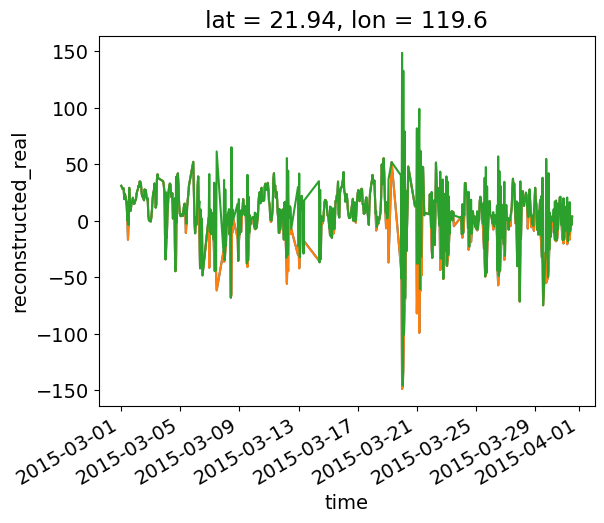

In [50]:
plt.plot(data_reconstructed.time,data_reconstructed.reconstructed)
data_reconstructed.masked.plot()
data_reconstructed.reconstructed_real.plot()

## Rotary spectrum

In [53]:
freq,f_k,ps,psd,data_return = nudft(u_detrended[:,10,10]+1j*v_detrended[:,10,10])

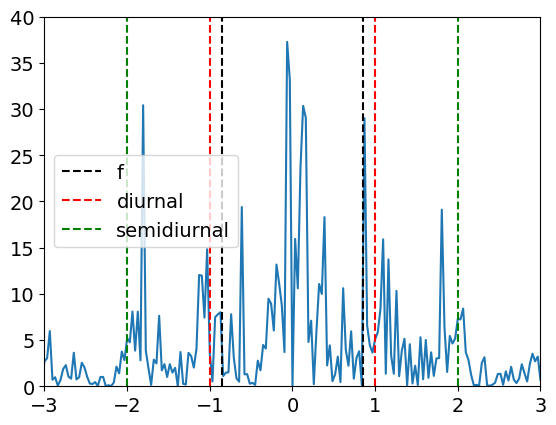

In [56]:
plt.plot(freq*24,ps)
plt.xlim([-3,3])
ymin,ymax = 0,40
plt.vlines([f_coriolis,-f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1,-1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2,-2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')

plt.legend()
plt.ylim([ymin,ymax]);

# Parcels

In [196]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

In [149]:
velocity.u.to_netcdf('/Users/2311043/Documents/TOROS_U_0315.nc')
velocity.v.to_netcdf('/Users/2311043/Documents/TOROS_V_0315.nc')

In [197]:
filenames = {'U': "/Users/2311043/Documents/TOROS_U_0315.nc",
             'V': "/Users/2311043/Documents/TOROS_V_0315.nc"}
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [198]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle,
                             size=5,            # releasing 5 particles
                             start=(121, 22),   # releasing on a line: the start longitude and latitude
                             finish=(121.5, 22))  # releasing on a line: the end longitude and latitude

In [199]:
output_file = pset.ParticleFile(name="/Users/2311043/Documents/TOROS_Parcels/toros.zarr", outputdt=timedelta(hours=6))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=1),
             dt=timedelta(minutes=5),
             output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\2311043\AppData\Local\Temp\parcels-tmp\lib0cef196e3e2f85a18c88e5a9d3aa42fb_0.dll


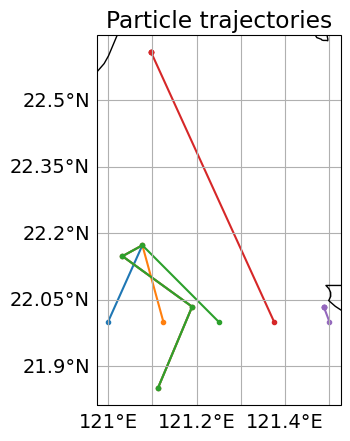

<module 'matplotlib.pyplot' from 'C:\\Users\\2311043\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [200]:
plotTrajectoriesFile("/Users/2311043/Documents/TOROS_Parcels/toros.zarr")

In [201]:
data = xr.open_zarr("/Users/2311043/Documents/TOROS_Parcels/toros.zarr").load()

In [203]:
data

<xarray.Dataset>
Dimensions:     (trajectory: 5, obs: 5)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4
  * trajectory  (trajectory) int64 35 36 37 38 39
Data variables:
    lat         (trajectory, obs) float32 22.0 22.17 22.15 ... 22.03 22.03 22.03
    lon         (trajectory, obs) float32 121.0 121.1 121.0 ... 121.5 121.5
    time        (trajectory, obs) datetime64[ns] 2015-03-01 ... 2015-03-02
    z           (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.1